In [11]:
import torch

# Load the tensor and map it to the CPU
data = torch.load('data_o_new2.pt', map_location=torch.device('cpu'))

# Print the shape of the tensor
print(data)



Data(x=[572, 128], edge_index=[2, 52112], edge_type=[52112])


MRCGNN Revised Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class Discriminator(nn.Module):
    def __init__(self, n_h):
        super(Discriminator, self).__init__()
        self.f_k = nn.Bilinear(32, 32, 1)
        for m in self.modules():
            self.weights_init(m)
    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)
    def forward(self, c, h_pl, h_mi, s_bias1=None, s_bias2=None):
        c_x = c.expand_as(h_pl)
        sc_1 = self.f_k(h_pl, c_x)
        sc_2 = self.f_k(h_mi, c_x)
        if s_bias1 is not None:
            sc_1 += s_bias1
        if s_bias2 is not None:
            sc_2 += s_bias2
        logits = torch.cat((sc_1, sc_2), 1)
        return logits

class AvgReadout(nn.Module):
    def __init__(self):
        super(AvgReadout, self).__init__()
    def forward(self, seq, msk=None):
        if msk is None:
            return torch.mean(seq, 0)
        else:
            msk = torch.unsqueeze(msk, -1)
            return torch.sum(seq * msk, 0) / torch.sum(msk)

class MRCGNN(nn.Module):
    def __init__(self, feature, hidden1, hidden2, decoder1, dropout, zhongzi):
        super(MRCGNN, self).__init__()

        # RGCN layers for the main (data_o) branch
        self.encoder_o1 = RGCNConv(feature, hidden1, num_relations=65)
        self.encoder_o2 = RGCNConv(hidden1, hidden2, num_relations=65)

        # Two-element parameter for layer attention
        self.attt = nn.Parameter(torch.tensor([0.5, 0.5]))
        self.disc = Discriminator(hidden2 * 2)
        self.dropout = dropout
        self.sigm = nn.Sigmoid()
        self.read = AvgReadout()
        
        # Final classifier: prediction solely from data_o branch.
        # Each node's final representation is a concatenation of (hidden1 + hidden2).
        # For a pair of entities, the dimension becomes 2*(hidden1+hidden2).
        self.classifier = nn.Linear(2 * (hidden1 + hidden2), 65)

        # We no longer load any pretrained features for skip connection.

    def forward(self, data_o, data_s, data_a, idx):
        # Process data_o branch
        x_o, adj, e_type = data_o.x, data_o.edge_index, data_o.edge_type
        e_type1 = data_a.edge_type
        e_type = torch.tensor(e_type, dtype=torch.int64)
        e_type1 = torch.tensor(e_type1, dtype=torch.int64)

        # Main branch for prediction (data_o)
        x1_o = F.relu(self.encoder_o1(x_o, adj, e_type))
        x1_o = F.dropout(x1_o, self.dropout, training=self.training)
        x2_o = self.encoder_o2(x1_o, adj, e_type)

        # Contrastive learning branches (unused in prediction)
        x_a = data_s.x
        x1_o_a = F.relu(self.encoder_o1(x_a, adj, e_type))
        x1_o_a = F.dropout(x1_o_a, self.dropout, training=self.training)
        x2_o_a = self.encoder_o2(x1_o_a, adj, e_type)

        x1_o_a_a = F.relu(self.encoder_o1(x_o, adj, e_type1))
        x1_o_a_a = F.dropout(x1_o_a_a, self.dropout, training=self.training)
        x2_o_a_a = self.encoder_o2(x1_o_a_a, adj, e_type1)

        # Readout for contrastive learning
        h_os = self.read(x2_o)
        h_os = self.sigm(h_os)
        ret_os = self.disc(h_os, x2_o, x2_o_a)
        ret_os_a = self.disc(h_os, x2_o, x2_o_a_a)

        # For final prediction, use only data_o branch:
        final = torch.cat((self.attt[0] * x1_o, self.attt[1] * x2_o), dim=1)

        a = [int(i) for i in list(idx[0])]
        b = [int(i) for i in list(idx[1])]
        aa = torch.tensor(a, dtype=torch.long)
        bb = torch.tensor(b, dtype=torch.long)
        entity1 = final[aa]
        entity2 = final[bb]
        concatenate = torch.cat((entity1, entity2), dim=1)
        log = self.classifier(concatenate)

        return log, ret_os, ret_os_a, x2_o

    def predict(self, data_o, idx):
        """
        New prediction method that uses only data_o and idx.
        """
        x_o, adj, e_type = data_o.x, data_o.edge_index, data_o.edge_type
        e_type = torch.tensor(e_type, dtype=torch.int64)
        # Process the main branch
        x1_o = F.relu(self.encoder_o1(x_o, adj, e_type))
        x1_o = F.dropout(x1_o, self.dropout, training=self.training)
        x2_o = self.encoder_o2(x1_o, adj, e_type)
        final = torch.cat((self.attt[0] * x1_o, self.attt[1] * x2_o), dim=1)
        
        a = [int(i) for i in list(idx[0])]
        b = [int(i) for i in list(idx[1])]
        aa = torch.tensor(a, dtype=torch.long)
        bb = torch.tensor(b, dtype=torch.long)
        entity1 = final[aa]
        entity2 = final[bb]
        concatenate = torch.cat((entity1, entity2), dim=1)
        log = self.classifier(concatenate)
        return log

Load My Model

In [13]:
model = MRCGNN(feature=128, hidden1=64, hidden2=32, decoder1=512, dropout=0.5, zhongzi=0)
model.load_state_dict(torch.load("model_mrcgnn.pt", map_location=torch.device('cpu')))
model.eval()

model.load_state_dict(torch.load("model_mrcgnn.pt", map_location='cpu'))
model.eval()

MRCGNN(
  (encoder_o1): RGCNConv(128, 64, num_relations=65)
  (encoder_o2): RGCNConv(64, 32, num_relations=65)
  (disc): Discriminator(
    (f_k): Bilinear(in1_features=32, in2_features=32, out_features=1, bias=True)
  )
  (sigm): Sigmoid()
  (read): AvgReadout()
  (classifier): Linear(in_features=192, out_features=65, bias=True)
)

In [231]:
import torch
import torch_geometric as pyg
from torch_geometric.utils import k_hop_subgraph, to_networkx, to_undirected
import networkx as nx
import numpy as np

# 1) LOAD YOUR DATA
data = torch.load('data_o_new2.pt', map_location=torch.device('cpu'))
print("Data object:", data)
# Data contains node features (data.x), edge information, etc.

# 2) EXTRACT COMPUTATION TREES & CREATE CONCEPT VECTOR
L = 1

# Convert directed edge index to undirected
edge_index_undirected = to_undirected(data.edge_index)
node_ctree_codes = []
unique_ctree_codes = {}

# Count node degrees (optional step for analysis)
degrees = torch.zeros(data.num_nodes, dtype=torch.long)
for i in range(data.edge_index.size(1)):
    degrees[data.edge_index[0, i]] += 1
print("Nodes with degree 0:", (degrees == 0).nonzero(as_tuple=True)[0])

# Helper function to generate a DFS code for the tree
def simple_dfs_code(G, root):
    code = []
    for n in nx.dfs_preorder_nodes(G, source=root):
        code.append(str(n))
    return "-".join(code)

# Iterate over every node in the graph
for v in range(data.num_nodes):
    # Extract the L-hop subgraph for node v
    subset, sub_edge_index, mapping, _ = k_hop_subgraph(
        node_idx=v,
        num_hops=L,
        edge_index=edge_index_undirected,
        relabel_nodes=False,  # or set to True for easier handling
        directed=False
    )
    
    # Create a subgraph data object and convert to NetworkX graph
    sub_data = pyg.data.Data(x=data.x[subset], edge_index=sub_edge_index)
    G_sub = to_networkx(sub_data, to_undirected=True)
    
    # Determine the correct root in G_sub (if not relabeled)
    root_in_sub = int(v) if v in subset else None
    if root_in_sub is None:
        raise RuntimeError(f"Node {v} not in its own k-hop subgraph")
    
    # Generate the DFS code representing the computation tree for node v
    """
    if subset.shape[0] > 1:
        ctree_code = simple_dfs_code(G_sub, root=root_in_sub)
    else:
        ctree_code = 0
    node_ctree_codes.append(ctree_code)
    
    """
    code = [str(root_in_sub)]
    ctree_code = "-".join(code)
    node_ctree_codes.append(ctree_code)
    
    
    # Map the code to a unique id if it hasn't been seen before
    unique_ctree_codes.setdefault(ctree_code, len(unique_ctree_codes))
    # print(unique_ctree_codes)

# Build the concept vector: count frequency of each unique computation tree
concept_vector = np.zeros(len(unique_ctree_codes), dtype=int)
for code in node_ctree_codes:
    idx = unique_ctree_codes[code]
    concept_vector[idx] += 1

print("Number of unique ctree codes:", len(unique_ctree_codes))
print("Concept vector (frequency of each code):")
print(concept_vector)

# Optionally print a sample of the unique computation trees and their frequencies
print("Sample unique computation tree codes and frequencies:")
for i, (code, idx) in enumerate(unique_ctree_codes.items()):
    if i >= 20:
        break
    freq = concept_vector[idx]
    print(f"Code {idx}: {code}")
    print(f"Frequency: {freq}\n")


Data object: Data(x=[572, 128], edge_index=[2, 52112], edge_type=[52112])
Nodes with degree 0: tensor([ 45, 336, 376, 557])
Number of unique ctree codes: 572
Concept vector (frequency of each code):
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [153]:
print(ctree_code)

print("Sample unique computation tree codes and frequencies:")
for i, (code, idx) in enumerate(unique_ctree_codes.items()):
    if i >= 50:
        break
    freq = concept_vector[idx]
    print(f"Code {idx}: {code}")
    print(f"Frequency: {freq}\n")

571-2-3-7-8-11-4-9-1-101-12-13-5-15-31-14-20-18-6-0-24-10-16-17-22-25-21-43-30-54-29-19-71-28-82-32-26-38-36-41-37-40-58-33-48-39-44-35-49-50-57-61-55-51-56-47-60-27-63-34-120-52-75-62-64-42-99-59-91-46-106-66-67-78-72-73-65-74-102-108-77-105-81-92-88-107-79-69-89-68-83-84-76-103-114-80-110-87-104-86-98-96-109-100-85-140-116-138-111-112-117-126-94-124-23-118-95-146-90-143-93-127-121-70-130-125-129-115-133-119-161-123-136-135-128-149-144-199-132-147-193-152-137-153-206-163-175-165-203-139-210-142-182-148-154-162-164-158-192-168-170-141-226-155-176-178-183-131-160-169-237-156-157-173-184-189-187-179-186-191-209-200-212-145-231-174-185-150-217-167-215-151-230-188-211-171-236-195-177-265-202-251-208-259-216-225-240-222-227-201-235-172-97-234-213-241-181-194-256-180-318-159-229-214-196-224-242-243-247-257-270-113-348-221-218-204-250-219-264-233-238-246-239-262-252-263-223-286-190-290-134-220-280-198-205-255-272-275-258-261-296-228-281-254-331-282-285-267-304-287-291-271-303-277-312-245-345-

DEFINE "REMOVE CONCEPTS" FUNCTION

In [195]:
def remove_concepts_from_graph(data, node_ctree_codes, unique_ctree_codes, subset_of_codes):
    """
    Prune out nodes whose L-hop code is not in 'subset_of_codes'.
    Returns a new Data object and a mapping dict (old_index -> new_index).
    """
    keep_nodes_list = []
    
    # Identify nodes to keep
    for v in range(data.num_nodes):
        if node_ctree_codes[v] in subset_of_codes:
            keep_nodes_list.append(v)
    
    new_data = data.clone()

    # Set anything other than keep_nodes_list to 0 for data.x
    for v in range(data.num_nodes):
        if v not in keep_nodes_list:
            new_data.x[v] = 0

    return data, keep_nodes_list

DEFINE A VALUE FUNCTION THAT RUNS MRCGNN

In [ ]:
def value_function(model, data, idx,
                   subset_of_codes, node_ctree_codes, unique_ctree_codes,
                   target_class=None):
    """
    1) Remove concepts not in 'subset_of_codes'
    2) Update idx based on the new node numbering
    3) Run model.predict() and return a scalar value.
    """
    # 1) Prune the graph.
    modified_data, keep_nodes_list = remove_concepts_from_graph(
        data, node_ctree_codes, unique_ctree_codes, subset_of_codes
    )
    # print(mapping)
    
    # 2) Update idx: For each index in idx, if it exists in keep_nodes_list, use the new index.
    new_src = []
    new_dst = []
    for src, dst in zip(idx[0].tolist(), idx[1].tolist()):
        if src in keep_nodes_list and dst in keep_nodes_list:
            new_src.append(src)
            new_dst.append(dst)
    if len(new_src) == 0 or len(new_dst) == 0:
        return 0.0  # no valid pairs remain

    new_idx = (torch.tensor(new_src, dtype=torch.long),
               torch.tensor(new_dst, dtype=torch.long))
    
    # 3) Forward pass
    with torch.no_grad():
        out = model.predict(modified_data, new_idx)  # shape: [num_pairs, 65]
        if out.shape[0] == 0:
            return 0.0

        if target_class is None:
            # Use the predicted class for each pair and average the logit.
            preds = out.argmax(dim=1)
            chosen_logits = out[torch.arange(out.size(0)), preds]
            val = chosen_logits.mean().item()
        else:
            chosen_logits = out[:, target_class]
            val = chosen_logits.mean().item()
    return val


SHAPLEY VALUES (SAMPLING APPROACH)

In [210]:
def shapley_values(model, data, idx,
                   unique_ctree_codes, node_ctree_codes,
                   target_class=None,
                   num_samples=50):
    """
    Approximate Shapley values via random permutations.
    """
    concepts = list(unique_ctree_codes.keys())  # DFS-code strings
    M = len(concepts)
    shap = np.zeros(M, dtype=float)

    for i in range(num_samples):
        print(i)
        perm = np.random.permutation(M)
        current_subset = set()
        old_val = value_function(
            model, data, idx,
            current_subset, node_ctree_codes, unique_ctree_codes,
            target_class
        )
        for j in range(M):
            c_idx = perm[j]
            c_code = concepts[c_idx]
            new_subset = current_subset.union({c_code})
            new_val = value_function(
                model, data, idx,
                new_subset, node_ctree_codes, unique_ctree_codes,
                target_class
            )
            print(j, new_val, old_val)
            shap[c_idx] += (new_val - old_val)
            current_subset = new_subset
            old_val = new_val
        print(shap)

    shap /= num_samples
    code2shap = {concepts[i]: shap[i] for i in range(M)}
    return code2shap


RUN SHAPLEY & DISPLAY RESULTS

In [241]:
"""
num_nodes = data.num_nodes
src_idx = torch.randint(0, num_nodes, (100,))
dst_idx = torch.randint(0, num_nodes, (100,))
idx = (src_idx, dst_idx)
"""
idx = random100
print(len(node_ctree_codes))

shap_vals = shapley_values(
    model=model,
    data=data,
    idx=idx,
    unique_ctree_codes=unique_ctree_codes,
    node_ctree_codes=node_ctree_codes,
    target_class=None,
    num_samples=10
)

# Sort Shapley results
sorted_shap = sorted(shap_vals.items(), key=lambda x: x[1], reverse=True)
print("\nTop-10 Concepts by Shapley Value:")
for c, val in sorted_shap:
    print(f"{c} => {val:.4f}")

# Done!

572
0
0 0.0 0.0
1 0.0 0.0
2 0.0 0.0
3 0.0 0.0
4 0.0 0.0
5 0.0 0.0
6 0.0 0.0
7 0.0 0.0
8 0.0 0.0
9 0.0 0.0
10 0.0 0.0
11 0.0 0.0
12 0.0 0.0
13 0.0 0.0
14 0.0 0.0
15 0.0 0.0
16 0.0 0.0
17 0.0 0.0
18 0.0 0.0
19 0.0 0.0
20 0.0 0.0
21 0.0 0.0
22 0.0 0.0
23 0.0 0.0
24 0.0 0.0
25 0.0 0.0
26 0.0 0.0
27 0.0 0.0
28 0.0 0.0
29 0.0 0.0
30 0.0 0.0
31 0.0 0.0
32 0.0 0.0
33 0.0 0.0
34 0.0 0.0
35 0.0 0.0
36 0.0 0.0
37 0.0 0.0
38 10.812345504760742 0.0
39 10.812345504760742 10.812345504760742
40 10.812345504760742 10.812345504760742
41 9.482468605041504 10.812345504760742
42 9.482468605041504 9.482468605041504
43 9.482468605041504 9.482468605041504
44 9.284893989562988 9.482468605041504
45 9.284893989562988 9.284893989562988
46 9.284893989562988 9.284893989562988
47 9.284893989562988 9.284893989562988
48 9.284893989562988 9.284893989562988
49 9.284893989562988 9.284893989562988
50 9.284893989562988 9.284893989562988
51 9.284893989562988 9.284893989562988
52 9.284893989562988 9.284893989562988
53 9.2848

KeyboardInterrupt: 

In [239]:
import matplotlib.pyplot as plt

L01_sample10 = sorted_shap

# Extract Shapley values from sorted_shap2
shap_values = [val for _, val in L01_sample10]

# Plot histogram with more bins for smaller bars
plt.figure(figsize=(10, 6))
plt.hist(shap_values, bins=20, edgecolor='black', alpha=0.7)  # Increase bins to make bars thinner
plt.title('L = 1, 10 Samples, Shapley Values')
plt.xlabel('Shapley Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("best")
for c, val in L01_sample10[:10]:
    print(f"{c} => {val:.4f}")

print("Least")
for c, val in L01_sample10[-10:]:
    print(f"{c} => {val:.4f}")

NameError: name 'L01_sample10' is not defined

(tensor([325,   2, 381, 528, 500, 441, 431, 492, 559, 185,   9,   4, 238, 389,
         43, 570, 467, 496, 432, 113,  18,  55, 226, 556, 325, 518,  90,  62,
        388, 193, 199, 540, 450, 410, 292, 553, 473,  52, 117, 143, 212, 463,
        444, 570, 487, 522, 533, 339, 480,  37, 336, 118, 128, 372, 315, 271,
        315,   3,  39, 483, 476, 541, 264, 121, 116, 183, 551, 548, 486,  20,
        309, 256, 158, 153, 519, 140,  26, 526,  21, 121, 189, 306, 103, 142,
        113, 456, 188, 141, 211,  66, 251, 460,  25, 165,  41, 442, 308, 365,
        354, 164]), tensor([455, 333, 221,  97, 107, 273, 544, 102, 543, 400, 337, 467,  52,  60,
        506, 389, 165,  62,  77, 274, 294, 493, 396, 117, 523, 338, 174, 122,
        254,  54, 466, 199, 346, 478, 278, 113, 232, 387, 322, 101, 335, 157,
        553, 486, 319,  25, 388, 509,  34, 197,  12, 126, 223, 315, 506, 348,
        498, 138,  20, 185, 527, 504, 157, 328, 308, 137, 469,  12, 553, 104,
        399,  91, 385,  73, 465, 207, 340, 

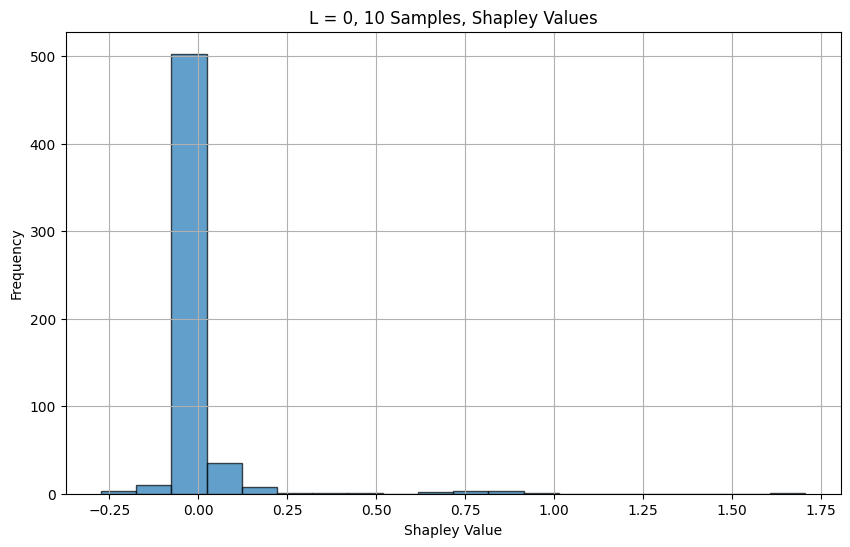

best
52 => 1.7059
221 => 1.0026
164 => 0.8694
338 => 0.8634
551 => 0.8244
62 => 0.8067
570 => 0.8048
308 => 0.7338
559 => 0.6444
116 => 0.6301
Least
533 => -0.0906
197 => -0.1063
478 => -0.1119
480 => -0.1170
336 => -0.1269
12 => -0.1335
60 => -0.1466
251 => -0.1840
34 => -0.2107
339 => -0.2737


In [243]:
print(random100)

import matplotlib.pyplot as plt

# Extract Shapley values from sorted_shap2
shap_values = [val for _, val in L0_sample10]

# Plot histogram with more bins for smaller bars
plt.figure(figsize=(10, 6))
plt.hist(shap_values, bins=20, edgecolor='black', alpha=0.7)  # Increase bins to make bars thinner
plt.title('L = 0, 10 Samples, Shapley Values')
plt.xlabel('Shapley Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("best")
for c, val in L0_sample10[:10]:
    print(f"{c} => {val:.4f}")

print("Least")
for c, val in L0_sample10[-10:]:
    print(f"{c} => {val:.4f}")

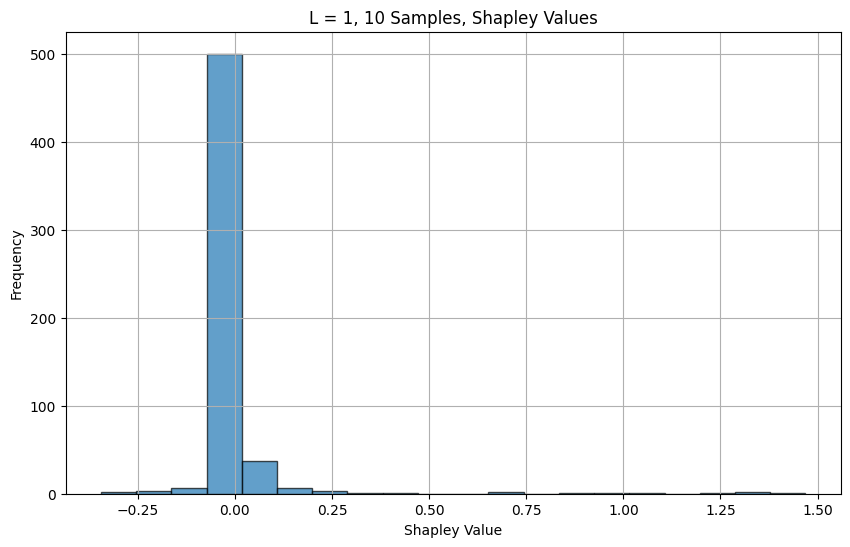

best
387-8-11-38-29-41-71-127-152-163-195-82-199-56-111-142-241-206-124-259-265-193-296-310-326-274-293-321-343-362-377-385-405-374-400-414-432-290-444-420-493-465-513-521-507-491-426-558-488-536-528 => 1.4688
185-4-9-13-33-43-48-24-84-52-55-38-108-60-58-64-72-89-106-74-112-111-114-91-94-124-121-132-138-135-174-130-146-150-203-195-210-151-215-152-250-204-280-198-217-212-246-231-264-289-255-275-299-324-286-315-311-281-331-290-305-348-346-352-317-323-399-353-401-359-388-380-411-421-440-422-431-418-428-486-433-466-444-483-465-493-506-511-513-521-545-494-569-568-529 => 1.3159
348-2-3-10-16-18-25-22-9-31-15-40-32-37-43-39-44-49-50-61-86-58-59-64-42-99-62-63-81-92-91-68-89-96-98-104-87-107-100-106-94-114-101-120-115-126-117-129-121-124-133-135-128-140-146-143-149-157-156-173-162-154-176-178-183-131-160-170-168-186-179-187-182-191-209-200-210-174-185-203-171-211-230-215-196-224-226-216-236-237-222-233-256-240-243-242-267-250-221-248-286-269-351-279-318-281-331-282-285-287-291-292-297-304-294-

In [229]:
import matplotlib.pyplot as plt

# Extract Shapley values from sorted_shap2
shap_values = [val for _, val in L1_sample10]

# Plot histogram with more bins for smaller bars
plt.figure(figsize=(10, 6))
plt.hist(shap_values, bins=20, edgecolor='black', alpha=0.7)  # Increase bins to make bars thinner
plt.title('L = 1, 10 Samples, Shapley Values')
plt.xlabel('Shapley Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("best")
for c, val in L1_sample10[:10]:
    print(f"{c} => {val:.4f}")

print("Least")
for c, val in L1_sample10[-10:]:
    print(f"{c} => {val:.4f}")

In [201]:
new_L0 = sorted_shap
import matplotlib.pyplot as plt

# Extract Shapley values from sorted_shap2
shap_values = [val for _, val in new_L0]

print("best")
for c, val in new_L0[:10]:
    print(f"{c} => {val:.4f}")

best
320 => 0.1509
361 => 0.1120
509 => 0.0899
27 => 0.0817
160 => 0.0707
408 => 0.0697
59 => 0.0682
52 => 0.0679
489 => 0.0632
430 => 0.0600


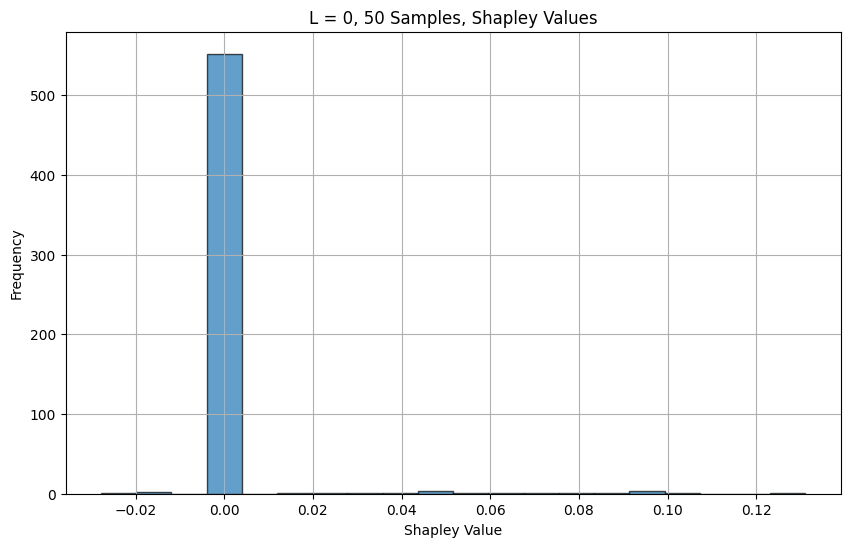

best
509 => 0.1311
164 => 0.1044
106 => 0.0973
Least
267 => -0.0135
77 => -0.0165
150 => -0.0278


In [202]:
import matplotlib.pyplot as plt

# Extract Shapley values from sorted_shap2
shap_values = [val for _, val in L0_sample50]

# Plot histogram with more bins for smaller bars
plt.figure(figsize=(10, 6))
plt.hist(shap_values, bins=20, edgecolor='black', alpha=0.7)  # Increase bins to make bars thinner
plt.title('L = 0, 50 Samples, Shapley Values')
plt.xlabel('Shapley Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("best")
for c, val in L0_sample50[:3]:
    print(f"{c} => {val:.4f}")

print("Least")
for c, val in L0_sample50[-3:]:
    print(f"{c} => {val:.4f}")

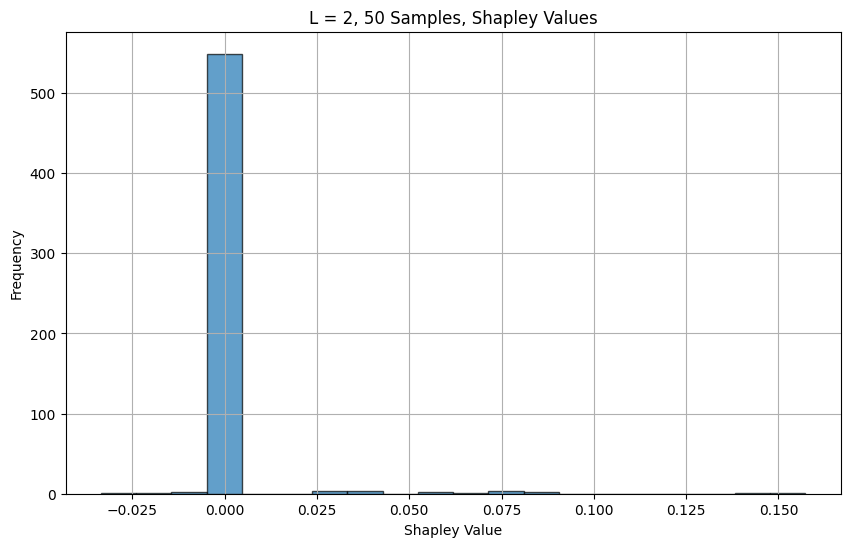

224-0-6-13-5-15-31-2-3-7-8-11-4-9-1-101-12-39-16-10-24-18-20-14-25-17-22-37-32-26-29-19-71-28-82-38-36-41-40-58-21-43-30-54-33-48-44-35-49-50-57-61-55-51-56-47-60-27-63-34-120-52-75-62-64-42-99-59-91-46-106-66-67-78-72-73-65-74-102-108-77-105-81-92-88-107-79-69-89-68-83-84-76-103-114-80-110-87-104-86-98-96-109-100-111-112-117-126-94-124-95-118-125-129-115-133-119-121-70-130-131-160-135-128-140-116-138-113-270-142-143-90-146-127-93-137-152-132-147-149-144-199-139-203-136-123-157-156-161-145-212-173-162-148-154-176-155-178-183-171-211-168-170-141-226-172-97-234-182-184-189-187-179-186-191-209-158-164-237-169-210-150-185-151-215-159-229-195-163-175-165-241-181-194-256-53-167-217-193-188-216-153-206-177-265-202-251-208-259-221-174-231-222-200-227-201-235-228-250-196-214-253-278-207-293-225-230-198-205-255-213-263-223-286-190-290-220-280-204-218-351-233-238-246-192-271-291-242-236-243-240-262-239-281-254-318-180-411-279-317-248-264-219-285-267-304-282-287-292-297-289-122-388-275-252-305-272

In [191]:
import matplotlib.pyplot as plt

# Extract Shapley values from sorted_shap2
shap_values = [val for _, val in L2_sample50]

# Plot histogram with more bins for smaller bars
plt.figure(figsize=(10, 6))
plt.hist(shap_values, bins=20, edgecolor='black', alpha=0.7)  # Increase bins to make bars thinner
plt.title('L = 2, 50 Samples, Shapley Values')
plt.xlabel('Shapley Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

for c, val in L2_sample50[:10]:
    print(f"{c} => {val:.4f}")

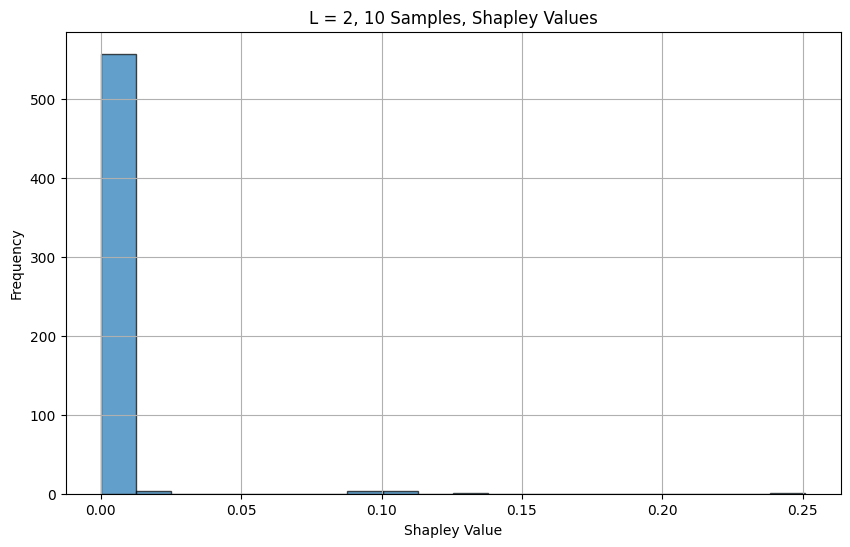

96-2-3-7-8-11-4-9-1-101-12-13-5-15-31-14-20-18-6-0-24-10-16-17-22-25-21-43-30-54-29-19-71-28-82-32-26-38-36-41-37-40-58-33-48-39-44-35-49-50-57-61-55-51-56-47-60-27-63-34-120-52-75-62-64-42-99-59-91-46-106-66-67-78-72-73-65-74-102-108-77-105-81-92-88-107-79-69-89-68-83-84-76-103-114-80-110-87-104-86-98-109-100-85-140-116-138-111-112-117-126-94-124-95-118-125-129-115-133-119-121-70-130-131-160-135-128-143-90-146-127-93-137-152-132-147-149-144-199-139-203-136-123-157-156-161-145-212-142-182-148-154-162-164-158-192-168-170-141-226-155-176-178-183-171-211-184-173-186-179-187-189-200-209-191-222-210-150-185-151-215-159-229-195-163-175-165-241-194-256-53-167-217-193-188-216-153-206-177-265-202-251-208-237-169-242-224-172-97-234-213-250-174-221-218-204-280-196-214-253-278-207-293-225-230-198-205-255-235-201-227-233-238-231-223-263-236-243-240-262-239-246-271-270-113-348-248-264-219-285-267-286-190-290-220-351-228-281-254-318-180-411-279-317-257-247-283-312-245-345-362-266-259-274-321-232-399-

In [193]:
import matplotlib.pyplot as plt

# Extract Shapley values from sorted_shap2
shap_values = [val for _, val in L2_sample10_2]

# Plot histogram with more bins for smaller bars
plt.figure(figsize=(10, 6))
plt.hist(shap_values, bins=20, edgecolor='black', alpha=0.7)  # Increase bins to make bars thinner
plt.title('L = 2, 10 Samples, Shapley Values')
plt.xlabel('Shapley Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

for c, val in L2_sample10[:10]:
    print(f"{c} => {val:.4f}")

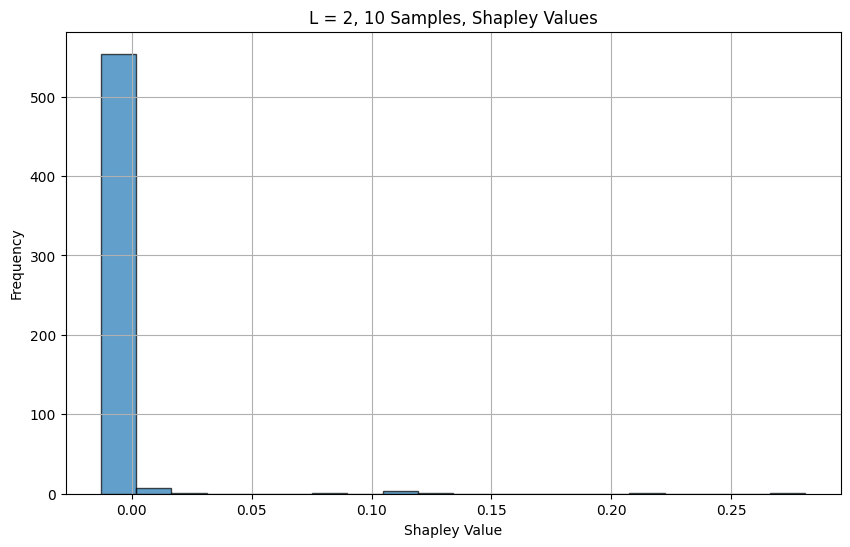

96-2-3-7-8-11-4-9-1-101-12-13-5-15-31-14-20-18-6-0-24-10-16-17-22-25-21-43-30-54-29-19-71-28-82-32-26-38-36-41-37-40-58-33-48-39-44-35-49-50-57-61-55-51-56-47-60-27-63-34-120-52-75-62-64-42-99-59-91-46-106-66-67-78-72-73-65-74-102-108-77-105-81-92-88-107-79-69-89-68-83-84-76-103-114-80-110-87-104-86-98-109-100-85-140-116-138-111-112-117-126-94-124-95-118-125-129-115-133-119-121-70-130-131-160-135-128-143-90-146-127-93-137-152-132-147-149-144-199-139-203-136-123-157-156-161-145-212-142-182-148-154-162-164-158-192-168-170-141-226-155-176-178-183-171-211-184-173-186-179-187-189-200-209-191-222-210-150-185-151-215-159-229-195-163-175-165-241-194-256-53-167-217-193-188-216-153-206-177-265-202-251-208-237-169-242-224-172-97-234-213-250-174-221-218-204-280-196-214-253-278-207-293-225-230-198-205-255-235-201-227-233-238-231-223-263-236-243-240-262-239-246-271-270-113-348-248-264-219-285-267-286-190-290-220-351-228-281-254-318-180-411-279-317-257-247-283-312-245-345-362-266-259-274-321-232-399-

In [162]:
import matplotlib.pyplot as plt

# Extract Shapley values from sorted_shap2
shap_values = [val for _, val in L2_sample10]

# Plot histogram with more bins for smaller bars
plt.figure(figsize=(10, 6))
plt.hist(shap_values, bins=20, edgecolor='black', alpha=0.7)  # Increase bins to make bars thinner
plt.title('L = 2, 10 Samples, Shapley Values')
plt.xlabel('Shapley Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

for c, val in L2_sample10[:10]:
    print(f"{c} => {val:.4f}")

In [145]:
shape_2 = sorted_shap
print(shape_2)

[('92-5-13-6-0-24-2-3-7-8-11-4-9-1-101-12-39-16-10-35-18-20-14-25-17-22-31-15-40-26-29-19-71-28-82-32-37-38-36-41-43-21-58-30-54-33-48-44-49-50-57-61-55-51-56-47-60-27-63-34-120-52-75-62-64-42-99-59-91-46-106-66-67-78-72-73-65-74-102-108-77-105-81-100-85-140-96-68-83-84-76-89-69-79-104-86-98-109-107-87-110-80-114-88-126-94-124-23-118-95-146-90-143-93-127-103-129-111-112-117-149-115-133-119-121-70-130-125-199-132-138-113-270-116-155-176-154-137-152-163-175-165-161-123-136-135-128-156-157-170-141-226-139-203-142-182-148-162-164-158-192-168-184-160-131-167-210-144-217-150-185-151-215-147-193-183-171-211-178-188-216-153-206-177-195-202-251-208-237-169-242-224-172-97-234-145-212-173-186-179-187-189-200-209-191-222-227-201-235-228-250-159-229-214-196-241-194-256-53-174-221-218-204-280-198-205-255-213-263-223-231-230-225-236-243-240-262-238-233-264-219-285-246-239-281-254-286-190-290-220-351-248-312-245-318-180-411-278-207-293-253-265-259-266-326-274-321-232-399-252-275-258-261-296-247-257-28

In [113]:
sorted_shap3  = sorted_shap
for c, val in sorted_shap2:
    print(f"{c} => {val:.4f}")

534-9-1-101-4-2-3-7-8-11-14-13-5-15-31-22-16-10-24-0-6-18-20-19-29-25-17-39-12-43-21-58-30-54-33-48-26-32-37-38-36-41-40-78-35-44-49-50-57-61-55-51-56-47-60-27-63-34-120-52-75-62-64-42-99-59-91-46-106-66-67-79-69-89-68-83-84-73-65-74-102-108-77-71-28-82-103-72-81-92-88-107-87-104-86-98-96-109-100-85-140-105-112-111-114-80-110-90-143-76-133-94-124-95-118-125-126-115-129-117-146-121-70-130-131-160-135-128-149-138-113-270-116-155-176-154-127-93-137-152-132-147-193-175-163-195-136-123-157-156-161-119-182-142-183-148-162-164-158-209-168-170-141-226-139-199-144-203-150-185-151-210-165-215-159-229-173-184-189-187-179-186-191-222-200-212-145-231-174-221-172-97-234-188-178-206-153-216-225-211-171-217-167-250-196-214-224-227-201-235-228-256-53-180-318-194-241-213-255-169-237-208-251-202-259-262-238-233-230-198-205-280-204-218-286-190-290-220-351-236-242-243-240-267-285-219-264-248-263-223-312-245-345-362-177-265-253-278-207-293-274-321-232-399-246-239-281-254-331-252-275-258-261-296-247-257-283-